In [1]:
import os
from datetime import datetime
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
import psycopg2
import pandas as pd
import geopandas as gpd
from geopandas import plotting
from shapely import wkb
import geocube
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
# import rioxarray
# import xarray as xr
import sys

In [2]:
# Database connection parameters
db_params = {
    "host": "",
    "port": "",
    "database": "",
    "user": "devtest",
    "password": ""
}
# Connect to the database
conn = psycopg2.connect(**db_params)
cur = conn.cursor()

In [3]:
# Define SQL Query to join tables
query = """  
    SELECT g.id, g.cell, a.geom, a.name_1
    FROM public.grid_005dd AS g
    JOIN thematic.gadm4_admin_level1_boundaries AS a ON ST_Intersects(g.cell, a.geom)
    WHERE a.name_1 = 'Mandera';
"""

In [4]:
# Execute the query and fetch the data
cur.execute(query)
data = cur.fetchall()

In [5]:
# Convert the fetched data into a DataFrame
column_names = ["grid_id", "geometry", "a_geom", "county_name"]
df = pd.DataFrame(data, columns=column_names)

# Convert the 'g005d_id' column to integer
df['grid_id'] = df['grid_id'].astype(int)

In [6]:
print(df)

      grid_id                                           geometry  \
0    15863330  0106000020E61000000100000001030000000100000005...   
1    15827327  0106000020E61000000100000001030000000100000005...   
2    15852522  0106000020E61000000100000001030000000100000005...   
3    15848928  0106000020E61000000100000001030000000100000005...   
4    15852521  0106000020E61000000100000001030000000100000005...   
..        ...                                                ...   
924  15834535  0106000020E61000000100000001030000000100000005...   
925  15830933  0106000020E61000000100000001030000000100000005...   
926  15841734  0106000020E61000000100000001030000000100000005...   
927  15830932  0106000020E61000000100000001030000000100000005...   
928  15823734  0106000020E61000000100000001030000000100000005...   

                                                a_geom county_name  
0    0103000020E610000001000000EF01000048110000667E...     Mandera  
1    0103000020E610000001000000EF010000481100

In [7]:
# Convert WKB to Shapely geometry for 'cell' and 'a'
df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x, hex=True))
df['a_geom'] = df['a_geom'].apply(lambda x: wkb.loads(x, hex=True))

In [8]:
# Create GeoDataFrames for 'cell' and 'a'
gdf = gpd.GeoDataFrame(df, geometry='geometry')
a = gpd.GeoDataFrame(df, geometry='a_geom')

In [9]:
print(gdf)

      grid_id                                           geometry  \
0    15863330  MULTIPOLYGON (((40.35000 3.55000, 40.35000 3.5...   
1    15827327  MULTIPOLYGON (((39.85000 3.70000, 39.85000 3.6...   
2    15852522  MULTIPOLYGON (((40.20000 3.95000, 40.20000 3.9...   
3    15848928  MULTIPOLYGON (((40.15000 3.65000, 40.15000 3.6...   
4    15852521  MULTIPOLYGON (((40.20000 4.00000, 40.20000 3.9...   
..        ...                                                ...   
924  15834535  MULTIPOLYGON (((39.95000 3.30000, 39.95000 3.2...   
925  15830933  MULTIPOLYGON (((39.90000 3.40000, 39.90000 3.3...   
926  15841734  MULTIPOLYGON (((40.05000 3.35000, 40.05000 3.3...   
927  15830932  MULTIPOLYGON (((39.90000 3.45000, 39.90000 3.4...   
928  15823734  MULTIPOLYGON (((39.80000 3.35000, 39.80000 3.3...   

                                                a_geom county_name  
0    POLYGON ((40.987487793000184 2.341545106000069...     Mandera  
1    POLYGON ((40.987487793000184 2.341545106

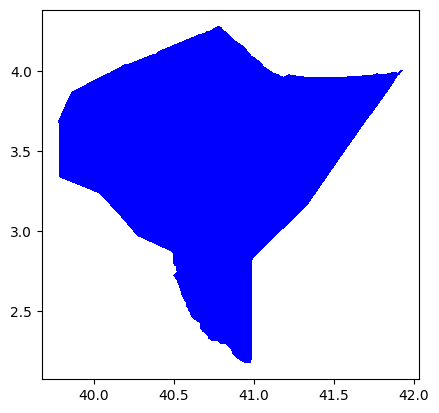

In [10]:
a_plot = a.plot(color='blue', alpha=0.5)

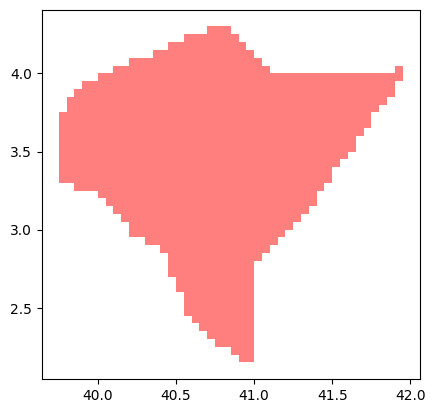

In [11]:
cell_plot = gdf.plot(color='red', alpha=0.5)

<Axes: >

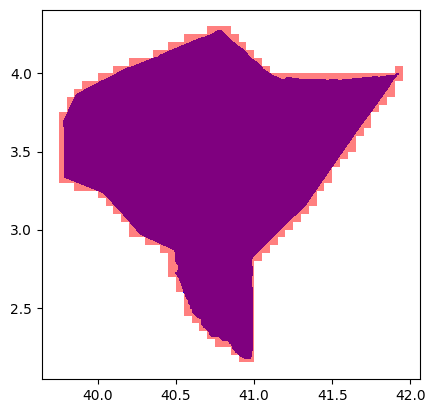

In [12]:
# Plot the overlay
ax = a.plot(color='blue', alpha=0.5)
gdf.plot(ax=ax, color='red', alpha=0.5)

In [13]:
# month ids
months_ids = [
    "01", "02", "03", "04", "05", "06",
    "07", "08", "09", "10", "11", "12"
]

In [14]:
# Base SQL
base_sql = "SELECT avg_rain_"
from_sql = " FROM rainfall_deficit.grid_005dd_long_term_rain WHERE g005d_id="

base_sql_current = "SELECT final_"
from_sql_current = " FROM rainfall_deficit.grid_005dd_chirps WHERE g005d_id="

# Defining period
from_date = "2022-01-01"
to_date = "2022-12-21"

from_date = datetime.strptime(from_date, '%Y-%m-%d')
to_date = datetime.strptime(to_date, '%Y-%m-%d')

# Decomposing the date
start_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')

from_year, from_month, from_decade = start_date.split('-')
to_year, to_month, to_decade = end_date.split('-')

if from_decade in ["01", "11"]:
    from_month = int(from_month)-1
    if from_month == 0:
        from_year = int(from_year)-1
        from_month = 12
    from_month = str(from_month)
    from_year = str(from_year)
    from_decade = str(21)

if to_decade in ["01", "11"]:
    to_month = int(to_month)-1
    if to_month == 0:
        to_year = int(to_year)-1
        to_month = 12
    to_month = str(to_month)
    to_year = str(to_year)
    to_decade = str(21)

In [15]:
# Create an empty list to store the results
results = []

# Loop through unique grid IDs in the DataFrame
for grid_id in gdf['grid_id'].unique():
    my_deficit = 0
    my_peak_deficit = float('inf')  # Set initial value to positive infinity
    my_peak_date = start_date
    my_expected_rainfall = 0

    for y in range(int(from_year), int(to_year)+1):
        start_month = int(from_month) if y == int(from_year) else 1
        end_month = int(to_month) if y == int(to_year) else 12

        for m in range(start_month, end_month+1):
            m_str = str(m).zfill(2)  # Convert to 2-digit format (e.g., '02' instead of '2')

            sql = base_sql + m_str + from_sql + str(grid_id)
            cur.execute(sql)
            avg = cur.fetchone()[0]

            sql = base_sql_current + m_str + from_sql_current + str(grid_id)
            cur.execute(sql)
            rain = cur.fetchone()[0]

            my_expected_rainfall = avg + my_expected_rainfall
            monthly_deficit = rain - avg

            my_deficit += monthly_deficit

            if monthly_deficit < my_peak_deficit:
                my_peak_deficit = monthly_deficit
                my_peak_date = str(y) + "-" + m_str + "-01"

    # Append the results to the list
    results.append({'grid_id': grid_id,
                    'from_date': start_date,
                    'to_date': end_date,
                    'peak_date': my_peak_date,
                    'peak_deficit': my_peak_deficit,
                    'deficit': my_deficit,
                    'expected_precipitation': my_expected_rainfall})

# Convert the list of dictionaries to a DataFrame
deficit_df = pd.DataFrame(results)

In [16]:
print(from_year)

2021


In [17]:
# Print the resulting DataFrame
print(deficit_df.head())

    grid_id   from_date     to_date   peak_date  peak_deficit  deficit  \
0  15863330  2022-01-01  2022-12-21  2022-10-01         -55.8   -112.0   
1  15827327  2022-01-01  2022-12-21  2022-10-01         -72.8   -139.0   
2  15852522  2022-01-01  2022-12-21  2022-10-01         -73.6    -76.2   
3  15848928  2022-01-01  2022-12-21  2022-10-01         -58.8   -117.0   
4  15852521  2022-01-01  2022-12-21  2022-10-01         -74.4    -80.8   

   expected_precipitation  
0                   486.0  
1                   549.0  
2                   533.2  
3                   503.0  
4                   556.8  


In [18]:
total_rows = len(deficit_df)
print("Total number of rows:", total_rows)

Total number of rows: 929


In [19]:
# Assuming that 'grid_id' is the common column between deficit_df and gdf
merged_df = pd.merge(deficit_df, gdf, on='grid_id')

In [20]:
# Create a GeoDataFrame from the merged DataFrame
gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

In [21]:
print(gdf)

      grid_id   from_date     to_date   peak_date  peak_deficit  deficit  \
0    15863330  2022-01-01  2022-12-21  2022-10-01         -55.8   -112.0   
1    15827327  2022-01-01  2022-12-21  2022-10-01         -72.8   -139.0   
2    15852522  2022-01-01  2022-12-21  2022-10-01         -73.6    -76.2   
3    15848928  2022-01-01  2022-12-21  2022-10-01         -58.8   -117.0   
4    15852521  2022-01-01  2022-12-21  2022-10-01         -74.4    -80.8   
..        ...         ...         ...         ...           ...      ...   
924  15834535  2022-01-01  2022-12-21  2022-10-01         -57.4   -123.6   
925  15830933  2022-01-01  2022-12-21  2022-10-01         -56.0   -130.8   
926  15841734  2022-01-01  2022-12-21  2022-10-01         -49.6   -138.6   
927  15830932  2022-01-01  2022-12-21  2022-10-01         -62.4   -149.2   
928  15823734  2022-01-01  2022-12-21  2022-10-01         -53.4   -127.2   

     expected_precipitation  \
0                     486.0   
1                     549

C:\Users\admin\AppData\Local\Temp\ipykernel_23296\4132373405.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_tick_labels)
C:\Users\admin\AppData\Local\Temp\ipykernel_23296\4132373405.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)


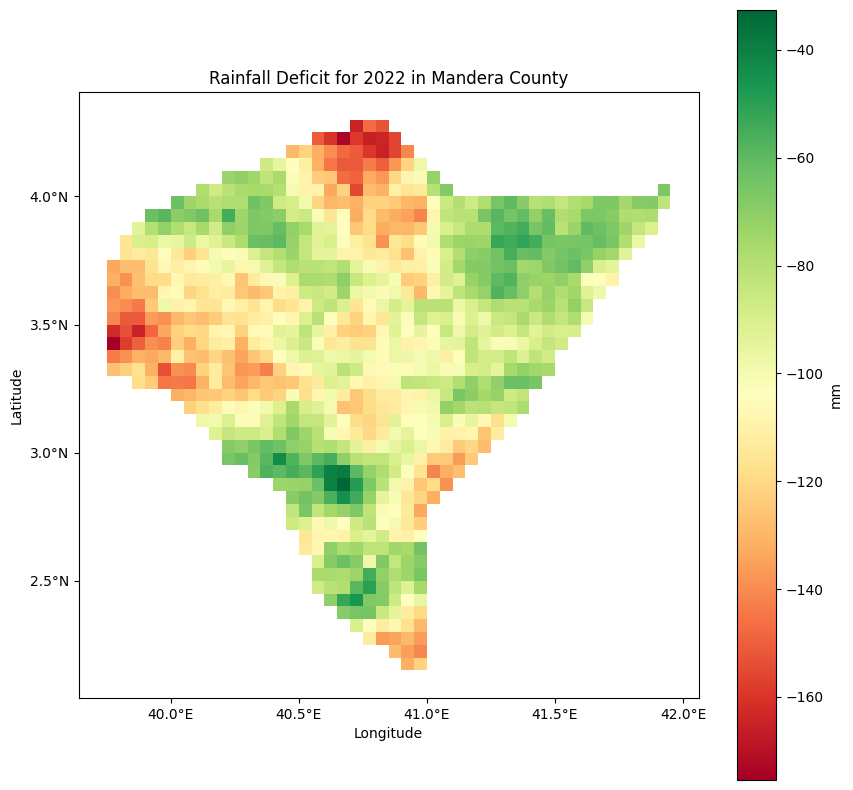

In [22]:
# Set the year
year = 2022

# Get the name_1 value from the DataFrame
name_1 = gdf['county_name'].iloc[9]

# Create a new figure and axis for the deficit
ax = gdf.plot(column=gdf['deficit'], cmap='RdYlGn', legend=True, legend_kwds={'label': "mm"}, figsize=(10, 10))

# Set the title for the current month with the year and name_1
ax.set_title(f'Rainfall Deficit for {year} in {name_1} County', fontsize=12)

# Set x and y axis labels with degrees and directions
ax.set_xlabel('Longitude', fontsize=10)  # Example label, adjust as needed
ax.set_ylabel('Latitude', fontsize=10)   # Example label, adjust as needed

# Set x and y axis ticks with directions
x_ticks = ax.get_xticks()
x_tick_labels = [f'{tick:.1f}°E' if tick >= 0 else f'{abs(tick):.1f}°W' for tick in x_ticks]
ax.set_xticklabels(x_tick_labels)

y_ticks = ax.get_yticks()
y_tick_labels = [f'{tick:.1f}°N' if tick >= 0 else f'{abs(tick):.1f}°S' for tick in y_ticks]
ax.set_yticklabels(y_tick_labels)

# Define the directory name
directory_name = f'{name_1}_{year}_deficit'

# Create the directory if it doesn't exist
os.makedirs(directory_name, exist_ok=True)

# Define the file name
file_name = f'{directory_name}/rainfall_deficit_{year}_{name_1}.png'

# Save the plot as an image
ax.figure.savefig(file_name, bbox_inches='tight', pad_inches=0)

In [23]:
# Set the resolution of the output GeoTIFF
resolution = (-0.005, 0.005)  # Adjust as needed

# Set the yeay
year = 2022

# Get the name_1 value from the DataFrame
name_1 = gdf['county_name'].iloc[9]

# Create a GeoCube
cube = make_geocube(vector_data=gdf, measurements=['deficit'], resolution=resolution)

# Convert cube to xarray Dataset
ds = cube.squeeze()

# Define the directory name
directory_name = f'{name_1}_2022_deficit_tiff_file'

# Create the directory if it doesn't exist
os.makedirs(directory_name, exist_ok=True)

# Export GeoTIFF
output_tiff_path = f'{directory_name}/{name_1}_{year}_Deficit.tiff'
ds.rio.to_raster(output_tiff_path, driver='GTiff')